**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Trabajo Práctico:** 1

**Datos de la entrega:** Jueves 26 de setiembre 2024, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo jupyter ( .IPYNB ) y todos los archivos adiconales que se requieran para correr su Cuaderno (En un archivo comprimido). En caso de requerir mucho espacio, solicitarle al profesor una carpeta en One-Drive para subir la solución.

---

**Estudiantes:**
- Andrey Arguedas Espinoza - 2020426569


# Trabajo Practico 1 - Andrey Arguedas Espinoza - 2020426569 - Parte 1

#### Considerations: 

#### • This notebook loads the whole dataset and only resizes the images in a 50% so in the basic version of Google Colab will not work, it is needed at least 20 MB RAM.

#### • If you run this in Anaconda or Jupyter Notebook yo need to 'pip install' all the required imports

## 0. Import required libraries


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras_tuner as kt
import seaborn as sns

from PIL import Image
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, BatchNormalization


## 1 - Load Data

### • We load initially the data from the CSV file

In [2]:
#Load data from CSV path
csv_path = './ham10000_metadata.csv'
df = pd.read_csv(csv_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11720 entries, 0 to 11719
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isic_id                 11720 non-null  object 
 1   attribution             11720 non-null  object 
 2   copyright_license       11720 non-null  object 
 3   age_approx              11337 non-null  float64
 4   anatom_site_general     9503 non-null   object 
 5   benign_malignant        9042 non-null   object 
 6   concomitant_biopsy      11720 non-null  bool   
 7   diagnosis               11720 non-null  object 
 8   diagnosis_confirm_type  11720 non-null  object 
 9   image_type              11719 non-null  object 
 10  lesion_id               11720 non-null  object 
 11  melanocytic             11720 non-null  bool   
 12  sex                     11377 non-null  object 
dtypes: bool(2), float64(1), object(10)
memory usage: 1.0+ MB


### • Now we build a dataset composed by the images and the corresponding label values (melanocytic = True/False)

### We also apply a resize of 50% on the images dimensions in order to reduce the memory consumption that we will have to do while building, splitting and handling the data

In [3]:
#Build dataset with images + corresponding label
def load_data(data_path, resize_dimensions = [0.5, 0.5]):
    images = []
    labels = []
    n = 0
    
    for filename in os.listdir(data_path):
        
        # Open the image
        img_path = os.path.join(data_path, filename)
        img = Image.open(img_path)
        # Calculate the new size
        new_size = (int(img.width * resize_dimensions[0]), int(img.height * resize_dimensions[1]))
        # Resize the image
        resized_img = img.resize(new_size, Image.LANCZOS)
        # Convert the image to a NumPy array for easier handling
        img_array = np.array(resized_img)

        # Add the new image arrary to list of data
        images.append(img_array)
        #We pair the label data with the image we are loading
        labels.append(df.loc[df['isic_id'] == filename.replace(".jpg", ""), 'melanocytic'].values[0])
        
        #Just to log the progress
        n += 1
        if n % 1000 == 0:
                print("Number of images loaded:", n) 

    return (np.array(images) , np.array(labels))

images_data_array, labels = load_data('./ISIC/', [0.5, 0.5])

print("Size of images for the dataset: ", images_data_array.shape)
print("Size of labels of the dataset: ",labels.shape)

Number of images loaded: 1000
Number of images loaded: 2000
Number of images loaded: 3000
Number of images loaded: 4000
Number of images loaded: 5000
Number of images loaded: 6000
Number of images loaded: 7000
Number of images loaded: 8000
Number of images loaded: 9000
Number of images loaded: 10000
Number of images loaded: 11000
Size of images:  (11720, 225, 300, 3)
Size of labels:  (11720,)


In [5]:
dataset_X = images_data_array
dataset_Y = labels

print("Size of images for the dataset: ", dataset_X.shape)
print("Size of labels of the dataset: ", dataset_Y.shape)

Size of images for the dataset:  (11720, 225, 300, 3)
Size of labels of the dataset:  (11720,)


## 2 - Visualize the first 10 images to see they are loading correctly and with its corresponding Melanocytic value

### * If the images are loading sorted by name you should see 9 images with Melanocytic = True and 1 image with Melanocytic = False

### * Note that the resize did not affect the aspect ratio of the images

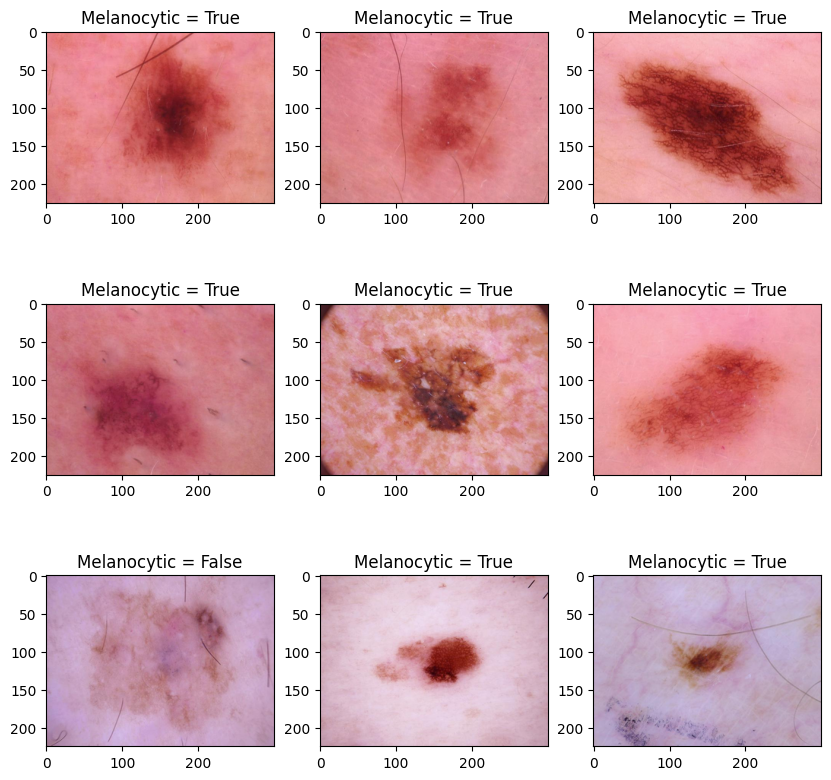

In [7]:
plt.figure(figsize=(10, 10))

for index, digit in zip(range(0, 9), dataset_X[:10]):
    plt.subplot(3, 3, index + 1)
    plt.imshow(digit)
    if dataset_Y[index] == True:
      plt.title("Melanocytic = True")
    else:
      plt.title("Melanocytic = False")
plt.show()

## 3 - Validate that we have the same proportion of True-False values from our loaded images as in the CSV data


In [20]:
print("**********Melanocytic: values distribution from data loaded from CSV files**************\n")
print(df['melanocytic'].value_counts() , "\n")

print("**********Melanocytic: values distribution from builded dataset **************\n")
unique_originals, counts_originals = np.unique(dataset_Y, return_counts=True)
print(str(unique_originals[1]) + " ----> " + str(counts_originals[1]))
print(str(unique_originals[0]) + " ----> " + str(counts_originals[0]))

**********Melanocytic: values distribution from data loaded from CSV files**************

melanocytic
True     9042
False    2678
Name: count, dtype: int64 

**********Melanocytic: values distribution from builded dataset **************

True ----> 9042
False ----> 2678


## 4 - Data Preparation and splitting the dataset


## - We split the data in a proportion of 60% training, 20% validation and 20% test

In [24]:
# Step 1: Split into train (60%) and remaining (40%)
X_train, X_remaining, y_train, y_remaining = train_test_split(dataset_X, dataset_Y, train_size=0.6)


# Step 2: Split remaining data into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5)

print("Dimensions of training data: ", X_train.shape)
print("Dimensions of training labels: ", y_train.shape)

print("Dimensions of validation data: ", X_val.shape)
print("Dimensions of validation labels: ", y_val.shape)

print("Dimensions of test data: ", X_test.shape)
print("Dimensions of test data: ", y_test.shape)


Dimensions of training data:  (7032, 225, 300, 3)
Dimensions of training labels:  (7032,)
Dimensions of validation data:  (2344, 225, 300, 3)
Dimensions of validation labels:  (2344,)
Dimensions of test data:  (2344, 225, 300, 3)
Dimensions of test data:  (2344,)


## **** - Visualize the first 3 images across splits to see them changing every time we run the notebook and make sure splits are working


********** Examples from Train Split***********


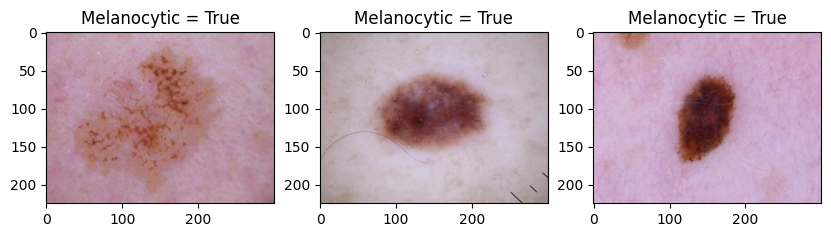

********** Examples from Validation Split***********


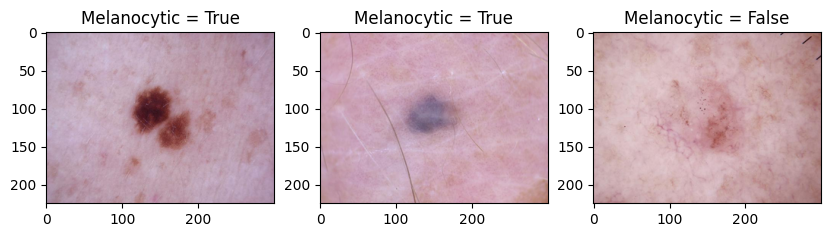

********** Examples from Test Split***********


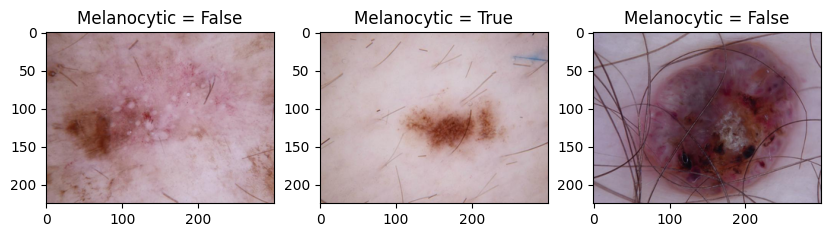

In [30]:
def plotImages(amount, data, labels):
    plt.figure(figsize=(10, 10))
    for index, digit in zip(range(0, amount), data):
        plt.subplot(amount, amount, index + 1)
        plt.imshow(digit)
        plt.title("Melanocytic = " + str(labels[index]))
    plt.show()

print("********** Examples from Train Split***********")
plotImages(3, X_train[:10], y_train)
print("********** Examples from Validation Split***********")
plotImages(3, X_val[:10], y_val)
print("********** Examples from Test Split***********")
plotImages(3, X_test[:10], y_test)

### - Now we do data normalization and pixel value transformation across our splitting data 

In [31]:
d1, d2, d3, d4 = X_train.shape

X_train_prep = X_train.reshape((d1, d2*d3*d4))
X_train_prep = X_train_prep.astype('float32') / 255

d1, d2, d3, d4 = X_val.shape

X_val_prep = X_val.reshape((d1, d2*d3*d4))
X_val_prep = X_val_prep.astype('float32') / 255

d1, d2, d3, d4 = X_test.shape

X_test_prep = X_test.reshape((d1, d2*d3*d4))
X_test_prep = X_test_prep.astype('float32') / 255



print("Example of pixel transformation for an image", X_train_prep[0])

Example of pixel transformation for an image [0.7019608  0.5529412  0.59607846 ... 0.54509807 0.38431373 0.45490196]


## 5-  Define the Neural Network Architecture and build model with Keras Tuner

In [32]:
def model_builder(hp):

    model = keras.Sequential()
    
    model.add(layers.Dense(
        units=hp.Int('units1', min_value=200, max_value=500, step=100),
        activation='relu'
    ))

    model.add(BatchNormalization())

    model.add(layers.Dense(
        units=hp.Int('units2', min_value=50, max_value=100, step=10),
        activation='relu'
    ))

    model.add(BatchNormalization())

    model.add(layers.Dense(
        units=hp.Int('units3', min_value=10, max_value=50, step=5),
        activation='relu'
    ))

    model.add(BatchNormalization())

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))


    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-2, max_value=0.1)
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision']
    )
    
    return model

## Instantiate Tuner object to do _hypertuning_

In [33]:
# Instantiate the tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=8,
    directory='test_dir',
    project_name='hp_tuning'
)

Reloading Tuner from test_dir\hp_tuning\tuner0.json


## Execute the tuner

In [34]:
tuner.search(
    X_train_prep,
    y_train,
    epochs = 8,
    validation_data=(X_val_prep, y_val)
)

### Visualize obtained hyperparameters

In [35]:
best_hp = tuner.get_best_hyperparameters()[0]

# Extract the best units and learning rate
best_units1 = best_hp.get('units1')
best_units2 = best_hp.get('units2')
best_units3 = best_hp.get('units3')
best_learning_rate = best_hp.get('learning_rate')

print(f" ******** Best units in first hidden layer: {best_units1}")
print(f" ******** Best units in second hidden layer: {best_units2}")
print(f" ******** Best units in third hidden layer: {best_units3}")
print(f"Best learning rate: {best_learning_rate}")


 ******** Best units in first hidden layer: 200
 ******** Best units in second hidden layer: 80
 ******** Best units in third hidden layer: 35
Best learning rate: 0.04039588485608032


### Summarize the best model obtained

In [38]:
model = tuner.hypermodel.build(best_hp)

model.build(input_shape=(None, X_train_prep.shape[1])) 
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               40500200  
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 80)                16080     
                                                                 
 batch_normalization_1 (Batc  (None, 80)               320       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 35)                2835      
                                                                 
 batch_normalization_2 (Batc  (None, 35)               1

## 6 - Training phase

In [39]:
history = model.fit(X_train_prep,
                      y_train,
                      epochs=10,
                      validation_data=(X_val_prep, y_val))

Epoch 1/10
220/220 [==============================] - 24s 102ms/step - loss: 0.4388 - accuracy: 0.7853 - precision: 0.8201 - val_loss: 2.5336 - val_accuracy: 0.7790 - val_precision: 0.7790
Epoch 2/10
220/220 [==============================] - 23s 103ms/step - loss: 0.4001 - accuracy: 0.8120 - precision: 0.8448 - val_loss: 0.5676 - val_accuracy: 0.6664 - val_precision: 0.9469
Epoch 3/10
220/220 [==============================] - 23s 103ms/step - loss: 0.3729 - accuracy: 0.8312 - precision: 0.8630 - val_loss: 0.4028 - val_accuracy: 0.8255 - val_precision: 0.8865
Epoch 4/10
220/220 [==============================] - 22s 99ms/step - loss: 0.3773 - accuracy: 0.8282 - precision: 0.8600 - val_loss: 0.5610 - val_accuracy: 0.8093 - val_precision: 0.8074
Epoch 5/10
220/220 [==============================] - 22s 100ms/step - loss: 0.3589 - accuracy: 0.8404 - precision: 0.8705 - val_loss: 0.8551 - val_accuracy: 0.5900 - val_precision: 0.9400
Epoch 6/10
220/220 [==============================] - 23

## 7 - Visualize metrics from the training phase

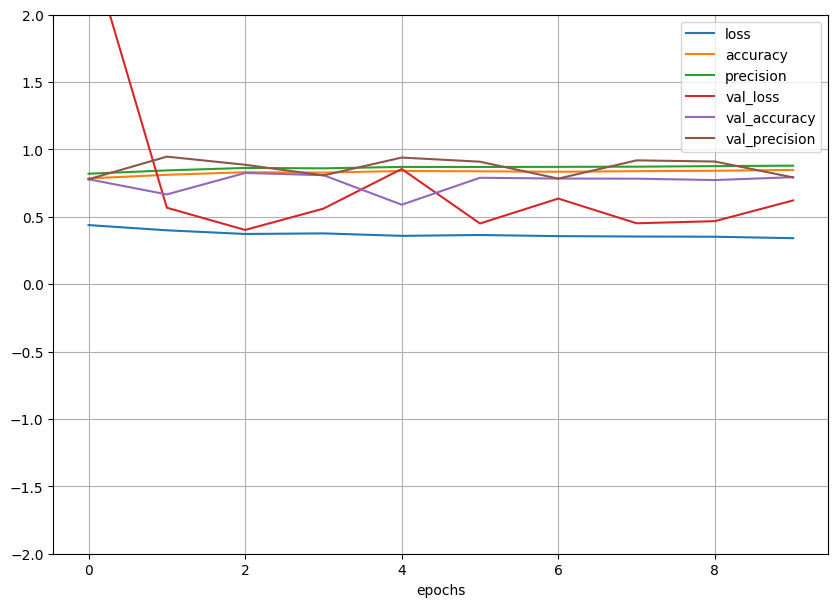

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(-2, 2)
plt.xlabel("epochs")
plt.show()

### • Check the accuracy, precision and loss

In [41]:
test_loss, test_acc, test_prec = model.evaluate(X_test_prep, y_test)
print('Test accuracy: ', test_acc)
print('Test Precision:', test_prec)
print('Test Loss:', test_loss)

74/74 [==============================] - 1s 18ms/step - loss: 0.6361 - accuracy: 0.7820 - precision: 0.7817
Test accuracy:  0.7819966077804565
Test Precision: 0.7817391157150269
Test Loss: 0.6360622644424438


## 8 - Final Results

74/74 [==============================] - 1s 16ms/step


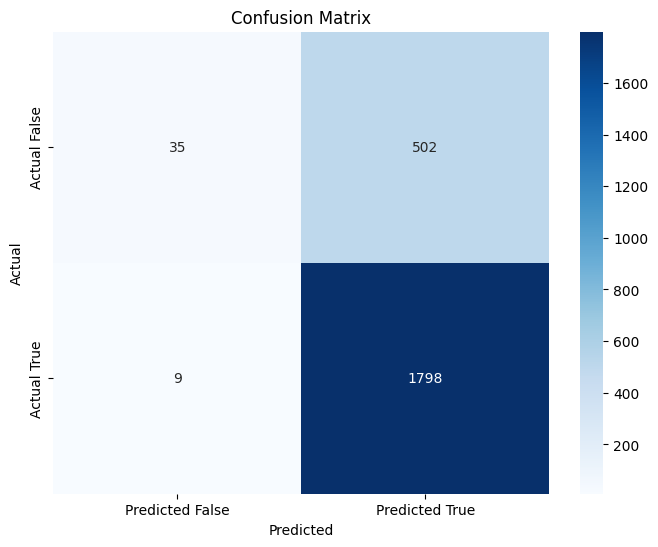

In [43]:
predictions = model.predict(X_test_prep)

y_pred = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted False', 'Predicted True'], yticklabels=['Actual False', 'Actual True'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## ** Conclusions Part 1 **

### This model is good at predicting the images with the Melanocytic = True, but is not very good at predicting the ones with that category on False

# Trabajo Practico 1 - Andrey Arguedas Espinoza - 2020426569 - Parte 2